# Data Pre-processing & Feature Selection

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available 
# on an “as is,” “as available,” and “with all faults” basis, solely for 
# illustrative purposes, and without warranty or representation of any kind. 
# This solution is experimental, unsupported and provided solely for your 
# convenience. Your use of it is subject to your agreements with Google, as 
# applicable, and may constitute a beta feature as defined under those 
# agreements.  To the extent that you make any data available to Google in 
# connection with your use of the solution, you represent and warrant that you 
# have all necessary and appropriate rights, consents and permissions to permit 
# Google to use and process that data.  By using any portion of this solution, 
# you acknowledge, assume and accept all risks, known and unknown, associated 
# with its usage, including with respect to your deployment of any portion of 
# this solution in your systems, or usage in connection with your business, 
# if at all.
###########################################################################

## 0) Dependencies

In [1]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = '' #add proj name

In [ ]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

import sys

# data processing libraries
import numpy as np
from numpy.core.numeric import NaN
import datetime
import pandas as pd
import pandas_gbq

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
!pip install boruta #boruta for feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm


import itertools
from scipy.stats.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5] #change size of plot
import seaborn as sns
import plotly.express as px

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics

magics.context.project = project_name  #update your project name 

client = bigquery.Client(project=magics.context.project)

## 1) Import dataset

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [3]:
%%bigquery df
SELECT *
FROM `.RBA_demo.SAMPLE_DATA`; #update with project name

In [4]:
df.head()

,geo,date,y1,x1,x2,x3,x4,x5,x6,x7,...,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
0,Northeast,2017-09-04 00:00:00+00:00,2258,48295480,1789,14961,21321,2934,27861,23083,...,458519,1886635,2358978,641381,7842969,3958070,0,1702231,2414536,1729212
1,Northeast,2017-09-05 00:00:00+00:00,3140,46867144,2017,19883,26379,3525,32136,32550,...,461112,1803811,2405801,587515,10018162,3717213,0,2236497,2788529,2568644
2,Northeast,2017-09-08 00:00:00+00:00,2253,52946853,1872,17798,23043,2807,28748,28317,...,326926,1462727,2295267,582325,8665153,2672611,0,1988181,2223178,1889816
3,Northeast,2017-09-09 00:00:00+00:00,1888,51527610,1800,15383,21023,3091,27638,24246,...,319552,1847868,1200901,488950,7422186,2386980,0,2213709,2303075,1786623
4,Northeast,2017-09-10 00:00:00+00:00,1623,51572539,2040,18561,24385,2943,30874,28190,...,301081,2010315,2496461,555649,7652613,2848655,0,1984963,2405399,1780011


Immediately remove variables that won't be used in the model. Here, includes columns like geo which is consistent across the dataset, and aggregated media such as total clicks across DSPs.


In [5]:
df.drop(columns = ['geo','x1','x2','x8','x18','x19','x20','x21','x22','x23','x24','x25'], inplace = True)

In [6]:
len(df.columns)

37

In [7]:
df.describe()

,y1,x3,x4,x5,x6,x7,x9,x10,x11,x12,...,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
count,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,...,6.070000e+02,6.070000e+02,6.070000e+02,6.070000e+02,6.070000e+02,6.070000e+02,607.00000,6.070000e+02,6.070000e+02,6.070000e+02
mean,2250.153213,9502.771005,21480.945634,1998.416804,24959.233937,21734.897858,11313.507414,9823.901153,2353.004942,4147.065898,...,5.795770e+05,6.292870e+05,2.203550e+06,7.684643e+05,7.349730e+06,3.258402e+06,134927.09061,5.758483e+06,5.627531e+05,5.263260e+05
std,461.357669,2917.877076,2305.487267,973.920668,2243.190985,4067.726939,1355.418519,1155.549656,975.569038,702.652872,...,2.725030e+05,6.565887e+05,4.796775e+05,2.591298e+05,2.712473e+06,1.615739e+06,140461.95610,4.002111e+06,4.465151e+05,5.300725e+05
min,1159.000000,5669.000000,15223.000000,0.000000,18347.000000,13897.000000,8146.000000,6488.000000,808.000000,2555.000000,...,0.000000e+00,0.000000e+00,8.618580e+05,0.000000e+00,2.201342e+06,0.000000e+00,0.00000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1924.000000,7296.500000,19855.000000,1121.000000,23432.500000,18349.000000,10240.000000,8993.000000,1475.000000,3597.500000,...,4.158335e+05,2.217570e+05,2.076954e+06,6.366825e+05,5.595286e+06,2.385656e+06,0.00000,4.004452e+06,2.915390e+05,2.476960e+05
50%,2227.000000,8455.000000,21373.000000,2017.000000,24824.000000,21768.000000,11411.000000,9868.000000,2327.000000,4094.000000,...,4.818750e+05,3.500790e+05,2.289272e+06,7.693830e+05,6.828403e+06,3.288012e+06,113893.00000,4.847731e+06,4.574400e+05,3.417130e+05
75%,2459.000000,11388.500000,23064.500000,2672.000000,26364.000000,24880.500000,12319.000000,10598.500000,3040.000000,4609.500000,...,7.237180e+05,8.936555e+05,2.495785e+06,8.642925e+05,8.298399e+06,4.326991e+06,223723.50000,6.381994e+06,6.308915e+05,5.509130e+05
max,3783.000000,19883.000000,28950.000000,6303.000000,32266.000000,32672.000000,15519.000000,13519.000000,6603.000000,6574.000000,...,1.518639e+06,3.147112e+06,3.174199e+06,3.772181e+06,1.840828e+07,1.248603e+07,876548.00000,2.299258e+07,2.898016e+06,3.341587e+06


In [12]:
#Set the date as index
date_col = "date" 
df = df.sort_values(date_col)
df = df.set_index(date_col)

Option to aggregate daily data to weekly

In [13]:
isDailyData = False #if you are using weekly data, please change this to False

In [14]:
if isDailyData == True:
  pass
else:
  df = df.resample('7D').sum() #aggregate daily data to weekly

In [15]:
df.head()

,y1,x3,x4,x5,x6,x7,x9,x10,x11,x12,...,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
date,,,,,,,,,,,,,,,,,,,,,
2017-09-01 00:00:00+00:00,17822,119647,164665,21534,207680,190533,85495,76818,24082,23809,...,3097339,11852723,16453211,4065524,59088712,25454626,0,14833112,17035234,13000785
2017-09-08 00:00:00+00:00,15200,123013,167171,22842,205607,201730,86336,78064,25204,23341,...,2275000,14231343,15450243,3960640,62100288,16626000,0,14628979,17439305,13501555
2017-09-15 00:00:00+00:00,14849,120377,163748,23721,203214,198886,84317,77574,25963,22710,...,2058667,15688359,14135379,3930680,54965325,48661357,0,19666246,14768707,13849732
2017-09-22 00:00:00+00:00,14718,111736,157919,23054,190367,193259,82399,72896,25520,21868,...,1013172,7181997,8700650,3974538,49135375,44478856,0,42476169,3895305,4381525
2017-09-29 00:00:00+00:00,15080,106156,155838,8967,180158,176646,82552,71653,10964,23683,...,1150303,1873587,7154967,4041503,47331061,42259198,0,38193618,3943760,1711429


## 2) Data Cleaning

### 2.1) Check for missing data and impute

Check the amount of of missing values (% of total column) in the data and sort by 
highest to lowest.

In [16]:
missing_values = 100*df.isnull().sum()/len(df)
missing_values.sort_values(ascending = False)

y1     0.0
x3     0.0
x31    0.0
x32    0.0
x33    0.0
x34    0.0
x35    0.0
x36    0.0
x37    0.0
x38    0.0
x39    0.0
x40    0.0
x41    0.0
x42    0.0
x43    0.0
x44    0.0
x45    0.0
x30    0.0
x29    0.0
x28    0.0
x11    0.0
x4     0.0
x5     0.0
x6     0.0
x7     0.0
x9     0.0
x10    0.0
x12    0.0
x27    0.0
x13    0.0
x14    0.0
x15    0.0
x16    0.0
x17    0.0
x26    0.0
x46    0.0
dtype: float64

If there are any NAs in the data that should be zeros, replace those data
points with zero.

In [17]:
df.fillna(0, inplace = True)

## 3) Define Y (KPI column) and create initial feature set

In [18]:
#Input column names for Y (ex: "new_accounts" or "sales") 
kpi_col = "y1" 
target_variable = df[kpi_col] #y variable

In [21]:
# Create a dataframe for features (all variables except date and kpi) x variables
featureset_df = df[df.columns[df.columns != date_col]]
featureset_df = df[df.columns[df.columns != kpi_col]]

In [22]:
featureset_df.head()

,x3,x4,x5,x6,x7,x9,x10,x11,x12,x13,...,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
date,,,,,,,,,,,,,,,,,,,,,
2017-09-01 00:00:00+00:00,119647,164665,21534,207680,190533,85495,76818,24082,23809,58418,...,3097339,11852723,16453211,4065524,59088712,25454626,0,14833112,17035234,13000785
2017-09-08 00:00:00+00:00,123013,167171,22842,205607,201730,86336,78064,25204,23341,58864,...,2275000,14231343,15450243,3960640,62100288,16626000,0,14628979,17439305,13501555
2017-09-15 00:00:00+00:00,120377,163748,23721,203214,198886,84317,77574,25963,22710,58058,...,2058667,15688359,14135379,3930680,54965325,48661357,0,19666246,14768707,13849732
2017-09-22 00:00:00+00:00,111736,157919,23054,190367,193259,82399,72896,25520,21868,56635,...,1013172,7181997,8700650,3974538,49135375,44478856,0,42476169,3895305,4381525
2017-09-29 00:00:00+00:00,106156,155838,8967,180158,176646,82552,71653,10964,23683,55113,...,1150303,1873587,7154967,4041503,47331061,42259198,0,38193618,3943760,1711429


## 4) Visualize Series

Optional:

Visualizing each series is useful to better understand the underlying distribution of the data. This allows for examination of outliers. 

Understanding the distribution of the underlying data can also inform prior parameterization in bayesian modeling approaches later on.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

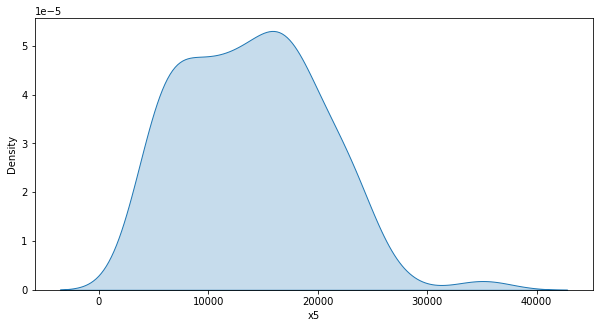

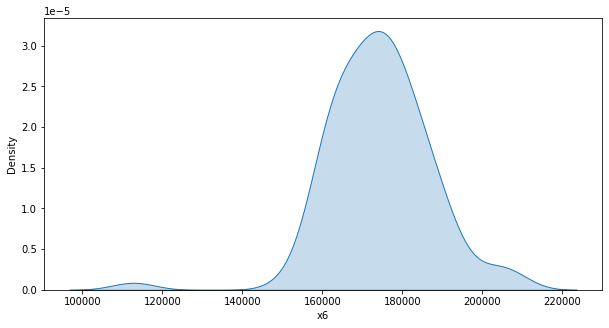

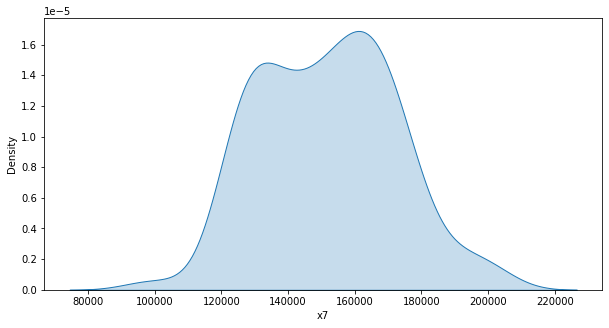

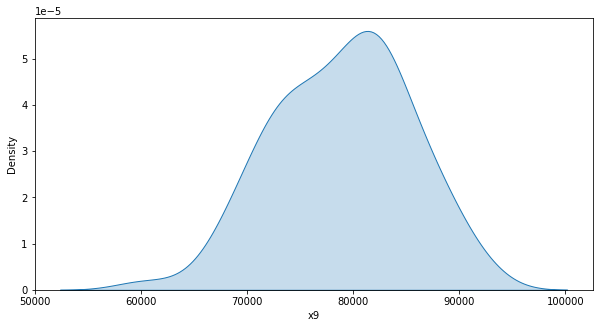

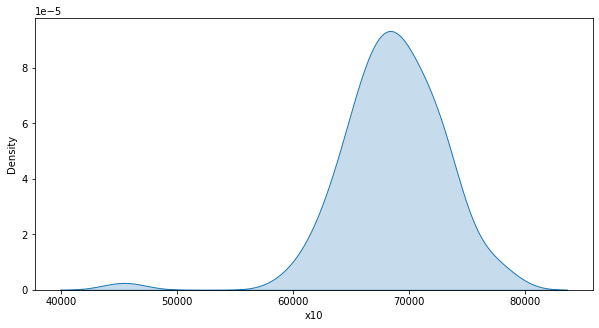

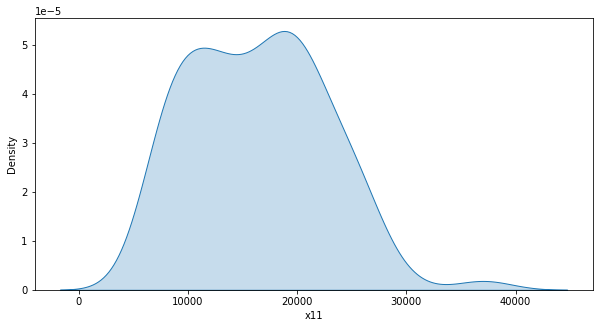

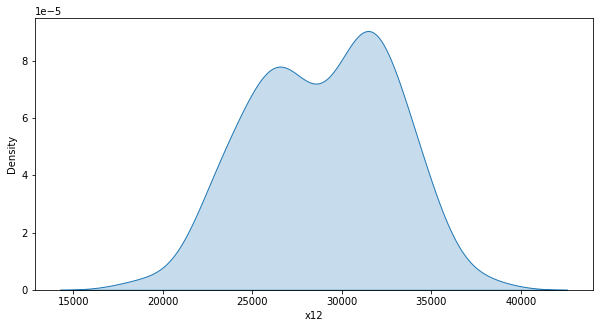

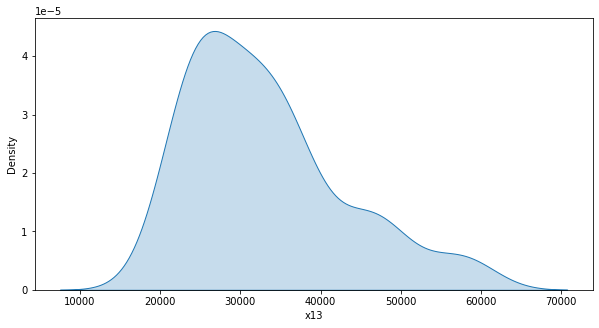

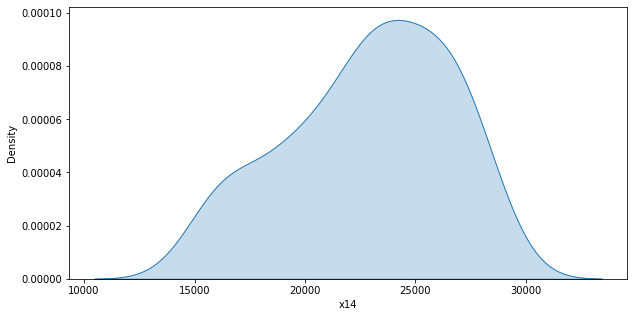

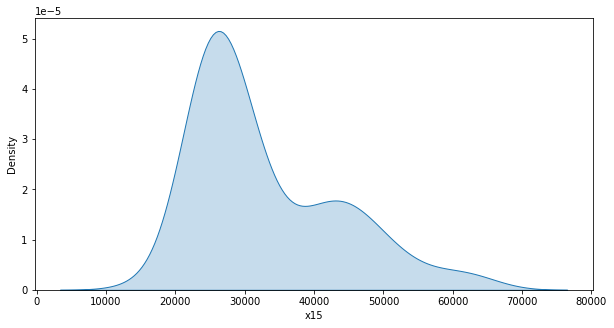

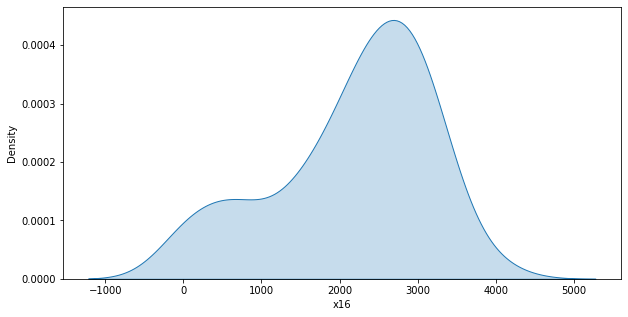

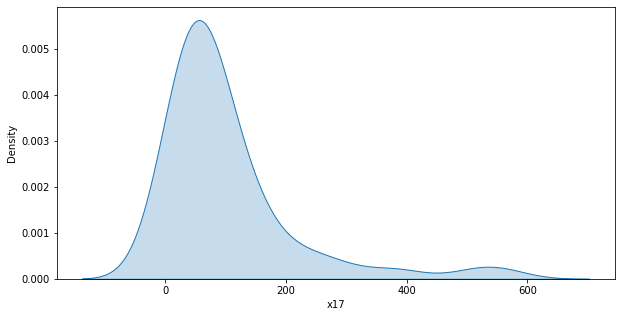

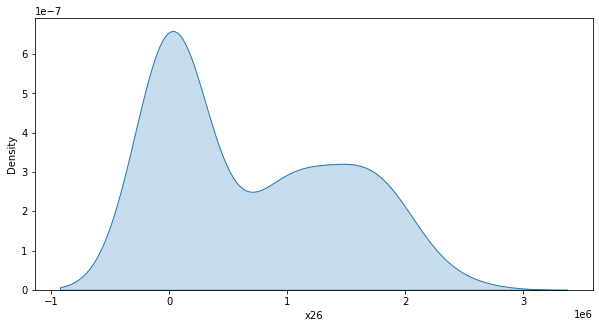

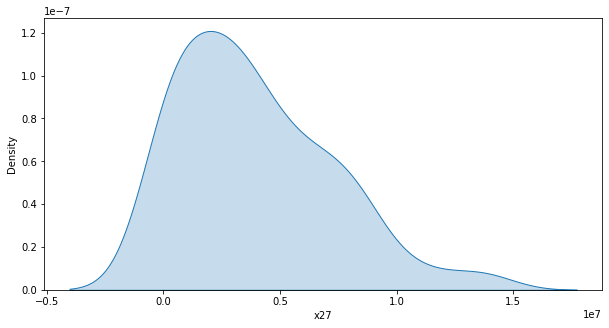

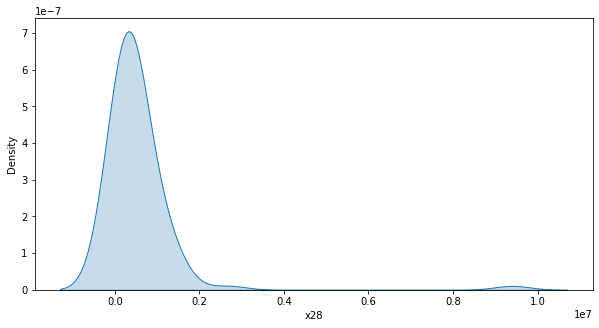

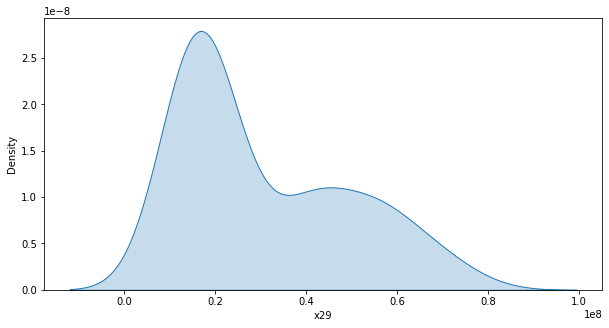

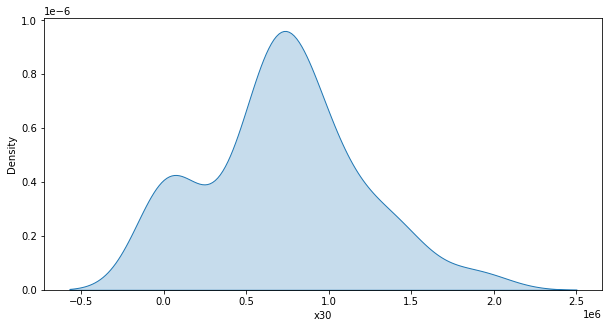

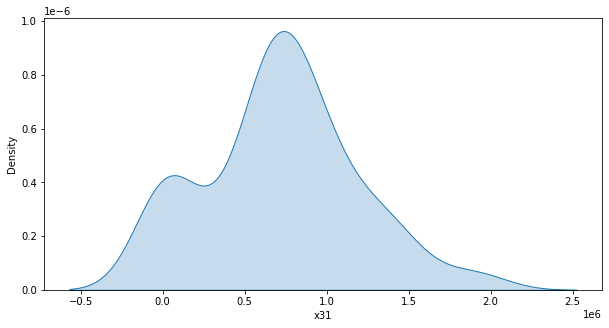

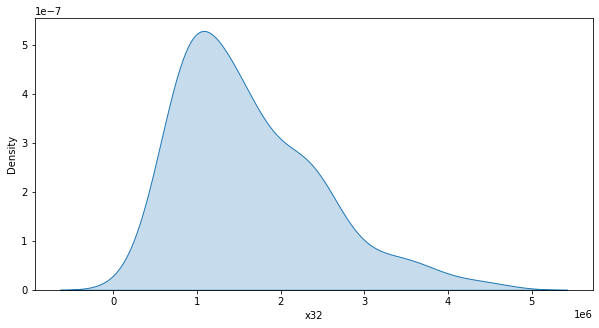

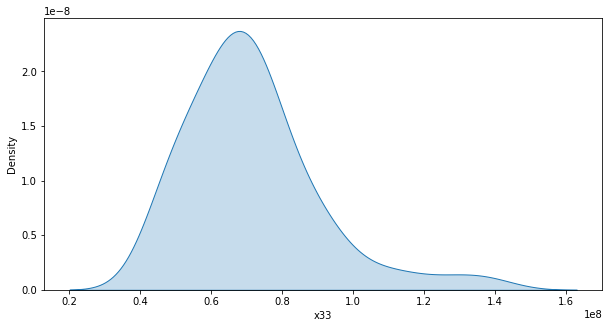

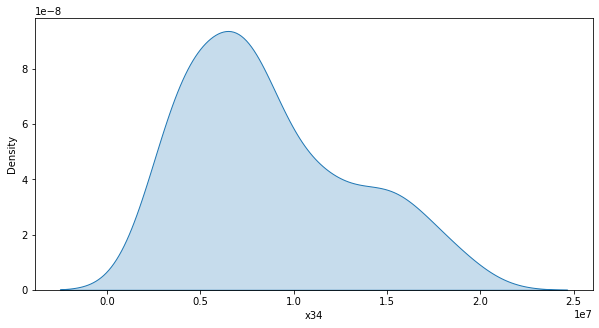

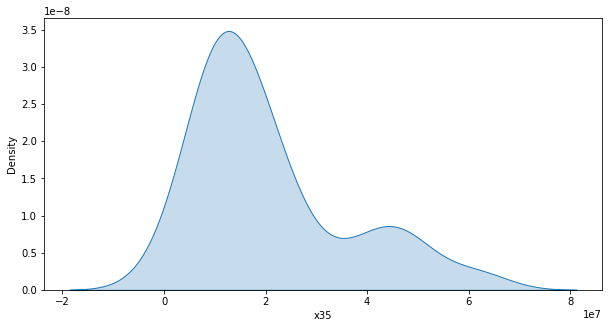

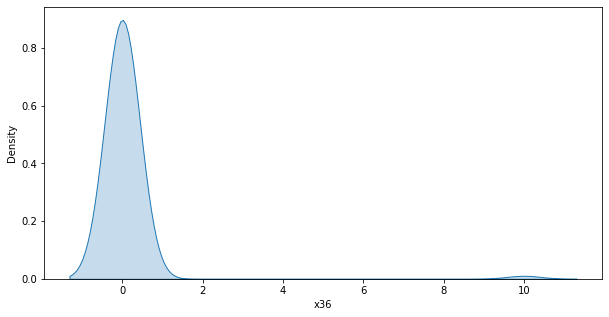

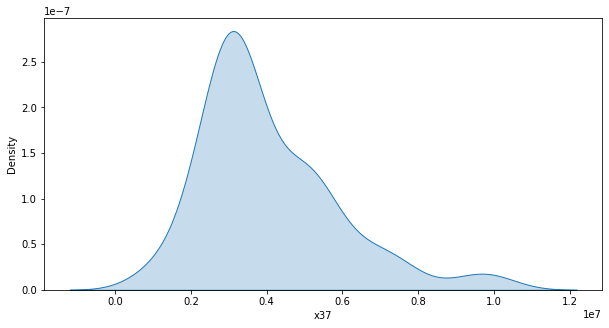

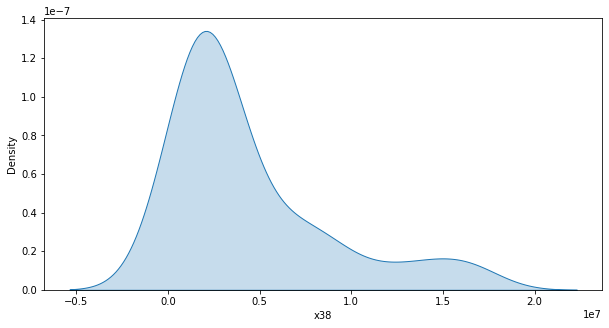

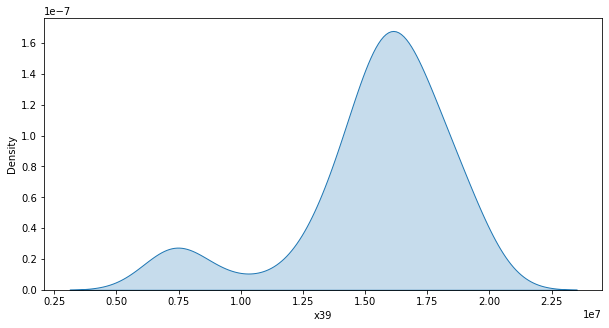

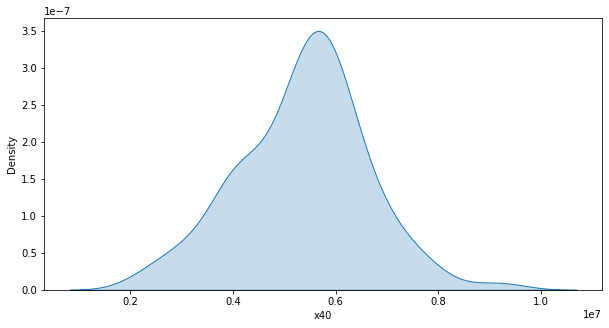

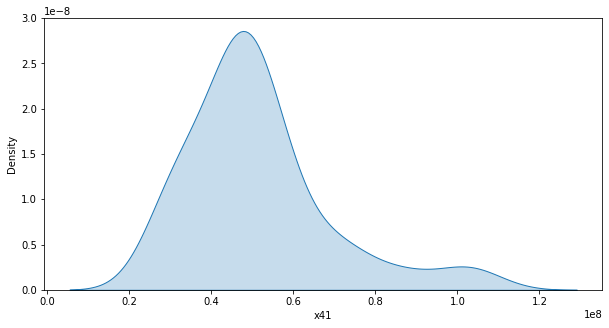

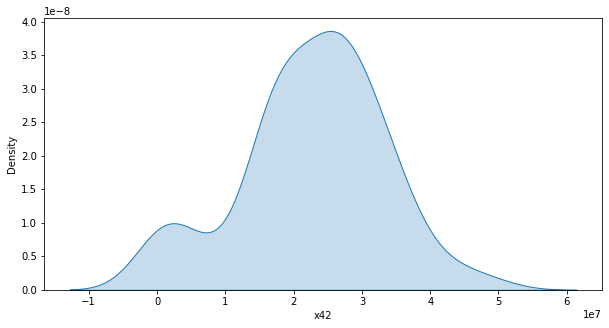

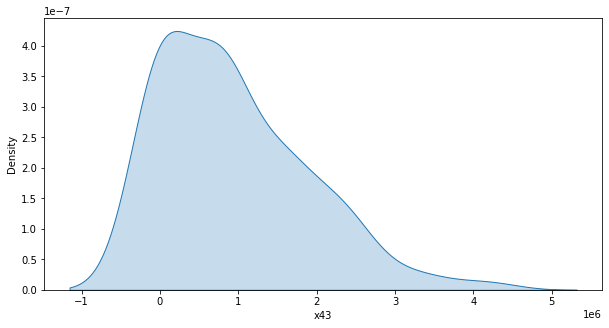

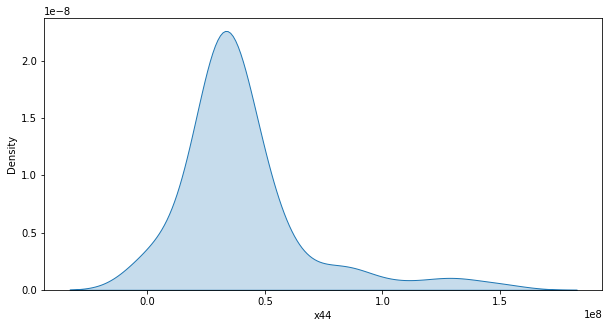

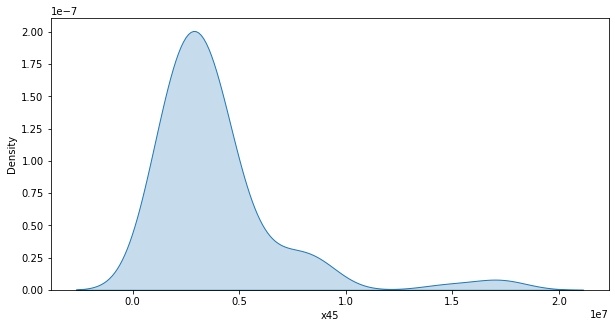

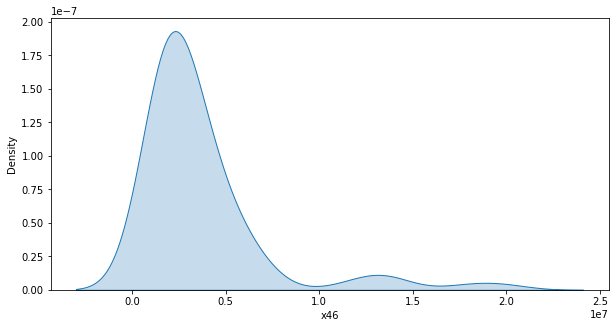

In [23]:
for i in range(2,len(featureset_df.columns)):
  plt.figure()
  sns.kdeplot(featureset_df[featureset_df.columns[i]], label = featureset_df.columns[i], shade = True)

## 5) Feature Creation

### 5.1) Check for Seasonality and add Flag

View the target variable as a time series plot and identify periods where data peaks.

We also add flags for periods of peak seasonality such as Q2, Q3, and major winter holidays.


In [24]:
fig = px.line(df['y1'])
fig.show()

In [25]:
featureset_df['Is_Q2Q3'] = (df.index.get_level_values(0).month == 4).astype(int) | (df.index.get_level_values(0).month == 5).astype(int) | (df.index.get_level_values(0).month == 6).astype(int) | (df.index.get_level_values(0).month == 7).astype(int) | (df.index.get_level_values(0).month == 8).astype(int) | (df.index.get_level_values(0).month == 9).astype(int)
featureset_df['Is_Holiday'] = ((df.index == '2017-11-17') | (df.index == '2017-12-22') | (df.index == '2018-11-16') | (df.index == '2018-12-21') | (df.index == '') | (df.index == ''))

### 5.2) Lag, Diminishing Returns, Adstock

We'll need to transform the raw data by applying lag, diminishing returns, and adstock returns to have it most accurately predict the target variable. 


- We define lag as the impact of media on sales "n" days after it was served.

- We define diminishing returns as the saturation point media will hit after a certain amount of spend, thereby becoming less effective for each additional dollar spent

- We define adstock as the effect of media spend across a number of days




First, split the df into two different dataframes:

1. Features that don't need to be transformed
      - Examples are: 
          - date
          - target variable
          - control variables (seasonality, promotions, etc.)

2. Features that do need to be transformed
      -  Paid media tactics 
      -  Any other feature where there is some sort of delayed response with the target variable


Starting points for lags:
- If you are using daily data, the lag should at default be 14.
- If you are using weekly data, the lag should at default be 5.

Others can and should be tested to determine the best lag length for your specific data.


In [26]:
# Variables that do not need to be transformed

untransformed_df = pd.concat([target_variable, featureset_df[['Is_Q2Q3','Is_Holiday']]], axis = 1) #Target variable + controls

In [27]:
# Variables that do need to be transformed

#exclude dummies/controls that do not need to be transformed
#transformed_df = featureset_df[['feature1', 'feature2',...]]

'''
Note: In this example case, almost all of the features in the featureset_df are media features.
As more dummy variables or other control variables are added, the user will need to 
specify which columns should be transformed
'''
transformed_df = featureset_df.loc[:,~featureset_df.columns.isin(['Is_Q2Q3','Is_Holiday'])]

#### 5.2.1) Create the transformation functions

In [28]:
# This function builds the values for the diminishing returns curve, which are
# later applied in the transformation step

def buildDReturnsValues(index, original_column, percent):
  if index == 0:
    return [original_column[0] * percent]
  else:
    previous_values = buildDReturnsValues(index-1, original_column, percent)
    previous_values.append(original_column[index] * percent + previous_values[index-1] * (1-percent))
    return previous_values

In [29]:
#This step can take several minutes
#This creates all combinations and then calculates the correlation between each variable and the Y variable. 
#Returns the top 3 highest correlated features

def createTransformations(df1, df2):
  columns = df2.columns
  sales = df1[[kpi_col]]
  all_data = [] 
  for col in columns:
    newdf = Transformation(df2, col, True)
    corr_df = pd.concat([sales, newdf], axis=1)
    corr = abs(corr_df.corr().sort_values(kpi_col, ascending=False))
    new_vals= corr.iloc[1:4 , 0:1].index.tolist()
    data = newdf[new_vals]
    all_data.append(data)
  final_data = pd.concat(all_data,axis=1)
  return final_data

In [30]:
#This function creates every combination of Lag, Adstock (carryover), and Diminishing Returns Shape
#The only thing that needs to be updated is this function is the lag  
# If you are using weekly data, keep range(0, 4, 1). This is testing lags from 0 - 4 weeks
# If you are using daily data, sugestion to update  range(0, 4, 1) to  range(0, 14, 1). This will test lags from 0 - 14 days.

def Transformation(dataframe, x, isDailyData=isDailyData):
    lag = []
    for i in range(0, 14 if isDailyData else 4 , 1):
        data = dataframe[x].shift(i).to_frame()
        data.columns = [col_name+'lag'+str(i)for col_name in data.columns]
        lag.append(data)
    lag = pd.concat(lag,axis=1)
    lag=lag.fillna(0)
    dreturns = []
    for i in np.linspace(0.6,1.0,num=5):
      data = pow(lag,i)
      data.columns = [col_name+'dreturns'+str(i)for col_name in data.columns]
      dreturns.append(data)
    dreturns = pd.concat(dreturns,axis=1) 
    adstock=[]
    #j = 0
    for percent in np.linspace(0.6,1.0,5):
        data = dreturns.copy()
        data.columns = [col_name+'adstock'+str(percent)for col_name in data.columns]
        for j in range(0, len(dreturns.columns)):
          data[data.columns[j]] = buildDReturnsValues(len(data[data.columns[j]])-1, data[data.columns[j]], percent)
        
        adstock.append(data)
        #j = j + 1
    adstock = pd.concat(adstock,axis=1)
    
    return adstock

#### 5.2.1) Implement the transformations

Make sure data is correctly sorted by date before running feature selection algo.

This is important because the algorithm takes from a previous row of the data as it evaluates the current row. Unsorted data can cause errors in resulting feature selection
info.


In [31]:
transformed_df = transformed_df.sort_values('date')
sys.setrecursionlimit(len(transformed_df.index)+100)

transformed_df = createTransformations(untransformed_df, transformed_df)
transformed_df.head()

,x3lag12dreturns0.8adstock1.0,x3lag12dreturns0.9adstock1.0,x3lag12dreturns0.7adstock1.0,x4lag0dreturns1.0adstock1.0,x4lag0dreturns0.9adstock1.0,x4lag0dreturns0.8adstock1.0,x5lag11dreturns1.0adstock0.6,x5lag11dreturns0.9adstock0.6,x5lag11dreturns1.0adstock0.7,x6lag0dreturns1.0adstock1.0,...,x43lag6dreturns0.6adstock1.0,x44lag11dreturns0.6adstock1.0,x44lag11dreturns0.6adstock0.9,x44lag11dreturns0.6adstock0.8,x45lag0dreturns0.6adstock0.7,x45lag0dreturns0.6adstock0.6,x45lag0dreturns0.6adstock0.8,x46lag0dreturns0.6adstock0.6,x46lag0dreturns0.6adstock0.7,x46lag0dreturns0.6adstock0.8
date,,,,,,,,,,,,,,,,,,,,,
2017-09-01 00:00:00+00:00,0.0,0.0,0.0,164665.0,49538.307958,14903.251786,0.0,0.0,0.0,207680.0,...,0.0,0.0,0.0,0.0,15272.386354,13090.616875,17454.155834,11130.969586,12986.131184,14841.292782
2017-09-08 00:00:00+00:00,0.0,0.0,0.0,167171.0,50216.315742,15084.424731,0.0,0.0,0.0,205607.0,...,0.0,0.0,0.0,0.0,20070.436446,18512.292927,21192.226070,15838.659051,17179.822441,18149.953512
2017-09-15 00:00:00+00:00,0.0,0.0,0.0,163748.0,49289.952978,14836.819165,0.0,0.0,0.0,203214.0,...,0.0,0.0,0.0,0.0,20039.694806,19420.829061,20259.661067,17897.013899,18642.422057,19045.391074
2017-09-22 00:00:00+00:00,0.0,0.0,0.0,157919.0,47707.971012,14412.771726,0.0,0.0,0.0,190367.0,...,0.0,0.0,0.0,0.0,12313.103460,13169.355926,11253.297949,12954.779535,12354.696256,11537.043516
2017-09-29 00:00:00+00:00,0.0,0.0,0.0,155838.0,47141.785703,14260.629367,0.0,0.0,0.0,180158.0,...,0.0,0.0,0.0,0.0,10042.039329,10708.978049,9505.640494,8479.273463,7553.330801,6703.890902


## 6) Feature Selection

For feature selection we employ the Boruta algorithm.[(More information here)](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a
)

This algorithm will tell you the rank of each feature and whether or not to keep a varaible in the model (i.e. Keep  = True/False). The goal of RBA is to optimize across all paid digital media tactics, therefore select the top ranking feature for each group of features (whether or not the algorithm tells you to keep the feature).


In [32]:
# Specifiying the target and x variables
y = target_variable
x = transformed_df #update with transformed features

In [33]:
# define random forest classifier
forest = RandomForestRegressor(n_jobs=-1, max_depth=5)
forest.fit(x, y)

RandomForestRegressor(max_depth=5, n_jobs=-1)

In [ ]:
# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
feat_selector.fit(np.array(x), np.array(y))

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(np.array(x))

In [35]:
#Select the top ranking variable for each group of variables. 
feature_ranks = list(zip(x.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('{:<25}, Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

x3lag12dreturns0.8adstock1.0, Rank: 75,  Keep: False
x3lag12dreturns0.9adstock1.0, Rank: 86,  Keep: False
x3lag12dreturns0.7adstock1.0, Rank: 81,  Keep: False
x4lag0dreturns1.0adstock1.0, Rank: 2,  Keep: False
x4lag0dreturns0.9adstock1.0, Rank: 2,  Keep: False
x4lag0dreturns0.8adstock1.0, Rank: 2,  Keep: False
x5lag11dreturns1.0adstock0.6, Rank: 54,  Keep: False
x5lag11dreturns0.9adstock0.6, Rank: 44,  Keep: False
x5lag11dreturns1.0adstock0.7, Rank: 47,  Keep: False
x6lag0dreturns1.0adstock1.0, Rank: 1,  Keep: True
x6lag0dreturns0.9adstock1.0, Rank: 1,  Keep: True
x6lag0dreturns0.8adstock1.0, Rank: 1,  Keep: True
x7lag12dreturns1.0adstock1.0, Rank: 32,  Keep: False
x7lag12dreturns1.0adstock0.9, Rank: 29,  Keep: False
x7lag12dreturns1.0adstock0.8, Rank: 54,  Keep: False
x9lag0dreturns0.6adstock1.0, Rank: 8,  Keep: False
x9lag0dreturns0.7adstock1.0, Rank: 1,  Keep: True
x9lag0dreturns0.8adstock1.0, Rank: 10,  Keep: False
x10lag0dreturns1.0adstock1.0, Rank: 17,  Keep: False
x10lag0dreturn

Reduce the overall dataset to just selected features using the ranking
from the Boruta output, and save to a dataframe

In [36]:
selected_featureset_df = transformed_df[['x3lag12dreturns0.8adstock1.0',
'x4lag0dreturns1.0adstock1.0',
'x5lag11dreturns0.9adstock0.6',
'x6lag0dreturns1.0adstock1.0',
'x7lag12dreturns1.0adstock0.9',
'x9lag0dreturns0.7adstock1.0',
'x10lag0dreturns0.9adstock1.0',
'x11lag11dreturns1.0adstock0.7',
'x12lag0dreturns0.9adstock1.0',
'x13lag12dreturns0.9adstock1.0',
'x14lag0dreturns1.0adstock1.0',
'x15lag12dreturns0.9adstock1.0',
'x16lag12dreturns0.6adstock0.7',
'x17lag0dreturns0.7adstock1.0',
'x26lag12dreturns0.6adstock0.6',
'x27lag0dreturns1.0adstock0.9',
'x28lag9dreturns0.8adstock0.6',
'x29lag12dreturns0.6adstock0.8',
'x30lag0dreturns1.0adstock1.0',
'x31lag0dreturns1.0adstock0.8',
'x32lag0dreturns0.6adstock0.6',
'x33lag12dreturns0.6adstock0.6',
'x34lag13dreturns1.0adstock0.6',
'x35lag12dreturns0.6adstock0.9',
'x36lag8dreturns1.0adstock0.6',
'x37lag12dreturns0.6adstock0.8',
'x38lag0dreturns0.7adstock0.9',
'x39lag12dreturns1.0adstock0.8',
'x40lag12dreturns1.0adstock0.6',
'x41lag12dreturns0.6adstock1.0',
'x42lag3dreturns1.0adstock0.6',
'x43lag4dreturns0.6adstock0.9',
'x44lag11dreturns0.6adstock0.8',
'x45lag0dreturns0.6adstock0.7',
'x46lag0dreturns0.6adstock0.6'
]]

In [37]:
# add back in the untransformed control variables to the featureset
selected_featureset_df = pd.concat([selected_featureset_df,untransformed_df[untransformed_df.columns[untransformed_df.columns != kpi_col]]],axis = 1)

## 7) Feature Scaling

### 7.1) Feature Scaling

The default method of standardization utilizes Standard Scaler, which takes in
input data and transforms so that the output has mean 0 and standard deviation of 1
across all features.


Alternative methods of feature scaling include square-root transformation,
de-meaning, natural log transformations, Min-Max Scalers, or normalization

In [38]:
scaler = StandardScaler()
standardized_transform = scaler.fit_transform(selected_featureset_df)
selected_featureset_df = pd.DataFrame(standardized_transform, columns = selected_featureset_df.columns)

Option to review visuals of the data. After the data is standardized the distributions may take on a more normal shape.

In [ ]:
'''
for i in range(0,len(X_transform_stand.columns)):
  plt.figure()
  sns.kdeplot(X_transform_stand[X_transform_stand.columns[i]], label = X_transform_stand.columns[i], shade = True)
'''

In [39]:
selected_featureset_df.head()

,x3lag12dreturns0.8adstock1.0,x4lag0dreturns1.0adstock1.0,x5lag11dreturns0.9adstock0.6,x6lag0dreturns1.0adstock1.0,x7lag12dreturns1.0adstock0.9,x9lag0dreturns0.7adstock1.0,x10lag0dreturns0.9adstock1.0,x11lag11dreturns1.0adstock0.7,x12lag0dreturns0.9adstock1.0,x13lag12dreturns0.9adstock1.0,...,x39lag12dreturns1.0adstock0.8,x40lag12dreturns1.0adstock0.6,x41lag12dreturns0.6adstock1.0,x42lag3dreturns1.0adstock0.6,x43lag4dreturns0.6adstock0.9,x44lag11dreturns0.6adstock0.8,x45lag0dreturns0.6adstock0.7,x46lag0dreturns0.6adstock0.6,Is_Q2Q3,Is_Holiday
0,-2.114036,1.542814,-1.869196,2.594289,-2.356551,1.021473,1.831496,-1.888804,-1.342473,-2.025863,...,-2.188687,-2.201208,-2.212638,-2.382530,-1.156057,-1.953263,2.202829,0.956528,1.218899,-0.219529
1,-2.114036,1.804188,-1.869196,2.433940,-2.356551,1.149135,2.104954,-1.888804,-1.467041,-2.025863,...,-2.188687,-2.201208,-2.212638,-2.382530,-1.156057,-1.953263,3.783365,2.414241,1.218899,-0.219529
2,-2.114036,1.447172,-1.869196,2.248839,-2.356551,0.842021,1.997467,-1.888804,-1.635391,-2.025863,...,-2.188687,-2.201208,-2.212638,-2.382530,-1.156057,-1.953263,3.773238,3.051600,1.218899,-0.219529
3,-2.114036,0.839212,-1.869196,1.255109,-2.356551,0.548221,0.967804,-1.888804,-1.860768,-2.025863,...,-2.188687,-2.201208,-2.212638,-0.776941,-1.156057,-1.953263,1.228006,1.521262,1.218899,-0.219529
4,-2.114036,0.622165,-1.869196,0.465432,-2.356551,0.571732,0.693114,-1.888804,-1.375986,-2.025863,...,-2.188687,-2.201208,-2.212638,-0.691584,-1.156057,-1.953263,0.479890,0.135444,1.218899,-0.219529


## 8) Handle Multicollinearity (reduce feature set)

1. Print a correlation heatmap to visualize correlations across feature set
2. Run variance inflation factor analysis and output results to flag multicollinearity above specified threshold

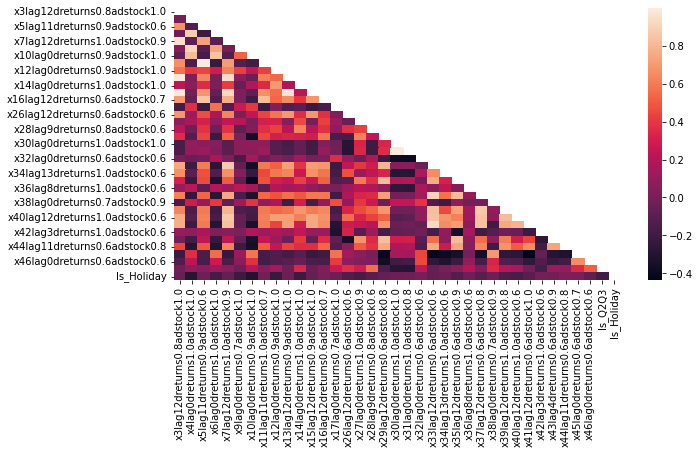

In [40]:
correl = selected_featureset_df.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(correl)

# using the upper triangle matrix as mask 
sns.heatmap(correl, mask=matrix)

Run VIF analysis and flag values greater than 10.

Industry best practice flags values above 10 as an extreme violation of regression model assumptions. [(Reference)](https://en.wikipedia.org/wiki/Variance_inflation_factor)


In [41]:
vif = add_constant(selected_featureset_df)

# loop to calculate the VIF for each X 
vif = pd.Series([variance_inflation_factor(vif.values, i) 
      for i in range(vif.shape[1])], 
      index=vif.columns) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [42]:
# processing to output VIF results as a dataframe 
vif_df=vif.to_frame().reset_index()

vif_df.columns = ['feature', 'vif']
vif_df=vif_df.replace([np.inf], np.nan) # replace inf calculations as missing and zero fill 
vif_df=vif_df.fillna(0).sort_values(by="vif", ascending=False)

In [43]:
vif_df.reset_index(inplace = True)
vif_df

,index,feature,vif
0,1,x3lag12dreturns0.8adstock1.0,1961.559923
1,3,x5lag11dreturns0.9adstock0.6,587.952362
2,10,x13lag12dreturns0.9adstock1.0,575.107472
3,8,x11lag11dreturns1.0adstock0.7,506.800327
4,12,x15lag12dreturns0.9adstock1.0,495.486278
5,5,x7lag12dreturns1.0adstock0.9,325.619811
6,20,x31lag0dreturns1.0adstock0.8,271.613032
7,2,x4lag0dreturns1.0adstock1.0,266.621342
8,19,x30lag0dreturns1.0adstock1.0,249.624477
9,22,x33lag12dreturns0.6adstock0.6,127.534209


Drop the highest VIF features and print the high collinearity columns in a list

In [44]:
high_collinearity_columns = vif_df.feature[vif_df['vif'] >= 10].to_list()
high_collinearity_columns

['x3lag12dreturns0.8adstock1.0',
 'x5lag11dreturns0.9adstock0.6',
 'x13lag12dreturns0.9adstock1.0',
 'x11lag11dreturns1.0adstock0.7',
 'x15lag12dreturns0.9adstock1.0',
 'x7lag12dreturns1.0adstock0.9',
 'x31lag0dreturns1.0adstock0.8',
 'x4lag0dreturns1.0adstock1.0',
 'x30lag0dreturns1.0adstock1.0',
 'x33lag12dreturns0.6adstock0.6',
 'x9lag0dreturns0.7adstock1.0',
 'x10lag0dreturns0.9adstock1.0',
 'x39lag12dreturns1.0adstock0.8',
 'x37lag12dreturns0.6adstock0.8',
 'x43lag4dreturns0.6adstock0.9',
 'x14lag0dreturns1.0adstock1.0',
 'x40lag12dreturns1.0adstock0.6',
 'x12lag0dreturns0.9adstock1.0',
 'x26lag12dreturns0.6adstock0.6',
 'x29lag12dreturns0.6adstock0.8',
 'x35lag12dreturns0.6adstock0.9',
 'x41lag12dreturns0.6adstock1.0',
 'x16lag12dreturns0.6adstock0.7',
 'x6lag0dreturns1.0adstock1.0',
 'x44lag11dreturns0.6adstock0.8',
 'x45lag0dreturns0.6adstock0.7',
 'x38lag0dreturns0.7adstock0.9',
 'x34lag13dreturns1.0adstock0.6',
 'Is_Q2Q3']

Drop 1 variable at a time (start with the highest VIF) and re-run the VIF cell to re-check multicollinearity. This will allow the user to preserve as many features in the model as possible.

In [45]:
cols_to_drop = []
while vif_df.vif[1] >= 10:
  if vif_df.vif[1] >= 10:
    cols_to_drop.append(vif_df.feature[1])
    selected_featureset_df.drop(columns = vif_df.feature[1],inplace = True) 
    vif = add_constant(selected_featureset_df)
  # loop to calculate the VIF for each X 
    vif = pd.Series([variance_inflation_factor(vif.values, i) 
    for i in range(vif.shape[1])], index=vif.columns) 
    # processing to output VIF results as a dataframe 
    vif_df=vif.to_frame().reset_index()
    vif_df.columns = ['feature', 'vif']
    vif_df=vif_df.replace([np.inf], np.nan) # replace inf calculations as missing and zero fill 
    vif_df=vif_df.fillna(0).sort_values(by="vif", ascending=False)
    vif_df.reset_index(inplace = True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [46]:
cols_to_drop

['x5lag11dreturns0.9adstock0.6',
 'x13lag12dreturns0.9adstock1.0',
 'x15lag12dreturns0.9adstock1.0',
 'x4lag0dreturns1.0adstock1.0',
 'x30lag0dreturns1.0adstock1.0',
 'x3lag12dreturns0.8adstock1.0',
 'x7lag12dreturns1.0adstock0.9',
 'x37lag12dreturns0.6adstock0.8',
 'x14lag0dreturns1.0adstock1.0',
 'x40lag12dreturns1.0adstock0.6',
 'x41lag12dreturns0.6adstock1.0',
 'x43lag4dreturns0.6adstock0.9',
 'x29lag12dreturns0.6adstock0.8',
 'x6lag0dreturns1.0adstock1.0']

In [47]:
selected_featureset_df.columns

Index(['x9lag0dreturns0.7adstock1.0', 'x10lag0dreturns0.9adstock1.0',
       'x11lag11dreturns1.0adstock0.7', 'x12lag0dreturns0.9adstock1.0',
       'x16lag12dreturns0.6adstock0.7', 'x17lag0dreturns0.7adstock1.0',
       'x26lag12dreturns0.6adstock0.6', 'x27lag0dreturns1.0adstock0.9',
       'x28lag9dreturns0.8adstock0.6', 'x31lag0dreturns1.0adstock0.8',
       'x32lag0dreturns0.6adstock0.6', 'x33lag12dreturns0.6adstock0.6',
       'x34lag13dreturns1.0adstock0.6', 'x35lag12dreturns0.6adstock0.9',
       'x36lag8dreturns1.0adstock0.6', 'x38lag0dreturns0.7adstock0.9',
       'x39lag12dreturns1.0adstock0.8', 'x42lag3dreturns1.0adstock0.6',
       'x44lag11dreturns0.6adstock0.8', 'x45lag0dreturns0.6adstock0.7',
       'x46lag0dreturns0.6adstock0.6', 'Is_Q2Q3', 'Is_Holiday'],
      dtype='object')

In [48]:
len(selected_featureset_df.columns)

23

In [49]:
# Replace the decimal points with underscores so that data can be exported to BQ
selected_featureset_df.columns = selected_featureset_df.columns.str.replace(".","_")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



## 9) Export Final Dataset

### 9.1) Trim the final dataset according to lag

In [50]:
final_df = selected_featureset_df
final_df['y1'] = target_variable.reset_index()[kpi_col]

In [51]:
final_df['date'] = df.index #add back in the date as a separate column from the index

Trim the start of your dataset to correspond with the max lag
(if max lag is 4 weeks, trim the first 4 weeks off of the data)

In [ ]:
max_lag = 13
final_df = final_df[max_lag:]
final_df.reset_index(inplace = True)
final_df.drop(columns = 'index',inplace = True)

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [55]:
destination_project_id = "" #@param
destination_dataset = "RBA_demo" #@param
destination_table = "cleaned_data" #@param
dataset_table = destination_dataset+"."+destination_table

final_df.to_gbq(dataset_table, 
                 destination_project_id,
                 chunksize=None, 
                 if_exists='replace'
                 )

1it [00:05,  5.81s/it]
